In [1]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import tensorflow as tf
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
import pandas as pd

In [2]:
print(y_test.shape,y_train.shape,x_test.shape,x_train.shape)

(10000,) (60000,) (10000, 28, 28) (60000, 28, 28)


Flatten the training and test x dfs

In [3]:
x_test.shape

(10000, 28, 28)

In [4]:
def flatten_x(X):
    x_flat = X.reshape(X.shape[0],-1)
    return x_flat

x_train_flat = flatten_x(x_train)
x_test_flat = flatten_x(x_test)

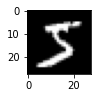

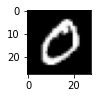

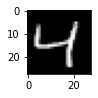

In [5]:
from matplotlib import pyplot
for i in range(3):  
    pyplot.subplot(330 + 1 + i)
    pyplot.imshow(x_train[i], cmap=pyplot.get_cmap('gray'))
    pyplot.show()

In [105]:
def create_samples(y_train):
    y_df = pd.Series(y_train).to_frame().rename(columns = {0:'value'})
    sample_dict1,sample_dict2,sample_dict3,sample_dict4 = {}, {}, {}, {}
    list_of_nos = np.linspace(0,9,10)
    for i in range(10):
        sample_dict1[i] = y_df[y_df['value'] == i].sample(50).index  
        sample_dict2[i] = y_df[y_df['value'] == i].sample(100).index  
        sample_dict3[i] = y_df[y_df['value'] == i].sample(200).index
    return sample_dict1, sample_dict2, sample_dict3
sample_dict1, sample_dict2, sample_dict3 = create_samples(y_train)

In [264]:
def create_x_dict(x_train,sample_dict1):
    x_dict = {}
    for i in range(10):
        x_dict[i] = x_train[sample_dict1[i],:]
    return x_dict

In [301]:
x_sample = create_x_dict(x_train,sample_dict2)

In [299]:
def compare_same_v_diff(x):
    euc_dist_same = []
    for number in range(10):
        for i in x[number]:
            for j in x[number]:
                comparison = i == j
                if comparison.all() == False:
                    euc_dis = np.linalg.norm(i-j)
                    euc_dist_same.append(euc_dis)

    euc_dist_diff = []
    for keys1,tables in x.items(): #iterate over the tables
        for rows in x[keys1]: #take each individual example from one of the dicts
            for keys2,tables2 in x.items(): #iterate over the dict again
                if keys1 != keys2: #ignore all the ones where you're looking at two of the same
                    for rows2 in x[keys2]: 
                        distance = np.linalg.norm(rows - rows2) #calculate distance
                        euc_dist_diff.append(distance) #add to the list

    return pd.DataFrame({'same':pd.Series(euc_dist_same).describe(),
                 'diff':pd.Series(euc_dist_diff).describe()}
                       ).astype('int32'), np.percentile(euc_dist_same,1), np.percentile(euc_dist_diff,1)

In [302]:
dafra, same5, diff5 = compare_same_v_diff(x_sample)
print(dafra)
print(f"1st percentile for same is {same5} \n\n1st percentile for different is {diff5}")

        same    diff
count  99000  900000
mean    2253    2389
std      352     322
min      698    1073
25%     2033    2158
50%     2255    2373
75%     2483    2598
max     3621    3647
1st percentile for same is 1368.9522891484967 

1st percentile for different is 1726.2906331196064


It looks like on average there's not too much difference, but with the 'same' ones there are some very very low values, although these are very rare. less than the top 1% is better than the best different value

Let's see what happens if we re-arrange the numbers to remove any whitespace at the top

In [ ]:
x_train_copy = x_train.copy()

In [226]:
def remove_white_space(datapoint):
    fst_row = 0
    count=0
    for row in datapoint:
        if np.sum(row) > 0:
            fst_row = count
            break
        else:
            count+=1
    datapoint = datapoint[fst_row:]
    datapoint = np.append(datapoint,np.zeros((fst_row,28)),axis=0)
    return datapoint

In [ ]:
count = 0 
for i in range(len(x_train_copy) + 1):
    x_train_copy[i] = remove_white_space(x_train_copy[i])
    count+=1

In [303]:
x_sample_copy = create_x_dict(x_train_copy,sample_dict2)

In [304]:
dafra_c, same5_c, diff5_c = compare_same_v_diff(x_sample_copy)
print(dafra_c)
print(f"1st percentile for same is {same5_c} \n\n1st percentile for different is {diff5_c}")

        same    diff
count  99000  900000
mean    2245    2372
std      355     324
min      650    1035
25%     2022    2142
50%     2245    2354
75%     2476    2580
max     3618    3664
1st percentile for same is 1358.7113968751605 

1st percentile for different is 1701.2029802461818


# not a lot of difference. which suggests a high precision model is needed

We can also say anything below 1000 is probably 'good enough' to stop the search at that point

maybe we run some form of K nearest neighbors and once we get a score below 1300, we then search the remaining values for that y value and see if we get a really good score

In [40]:

#my_own_knn
test_row = x_test_flat[4]
answer = 0
counter = 0
best = int()
for row in x_train_flat:
    distance = np.linalg.norm(test_row-row)
    if (best == 0) or (distance < best):
        best = distance
        answer = counter
    counter+=1
print(distance)
print(answer)
print(y_train[answer])
print(y_test[4])

2370.7600047242236
13252
4
4


In [8]:
def create_test_sample(X,Y,sample=5000):
    x_sample = X[0:sample,:]
    y_sample = Y[:sample]
    return x_sample, y_sample
x_sample, y_sample = create_test_sample(x_test_flat,y_test)

In [9]:

def sample_misclass(x_sample, y_sammple):
    test_predictions = one_nn.predict(x_sample)
    mis_classifications = 1-accuracy_score(y_sample,test_predictions)
    print(mis_classifications)

sample_misclass(x_sample,y_sample)
print(f"time took {time.time() - start_time} second")

NameError: name 'time' is not defined

In [10]:
import time

In [11]:
from sklearn.model_selection import cross_val_score
import numpy as np
start_time = time.time()
#create a new KNN model
ks = [1,3,5,10]
for k in ks:
    knn_cv = KNeighborsClassifier(n_neighbors=k)
    #train model with cv of 5 
    cv_scores = cross_val_score(knn_cv, x_sample, y_sample, cv=5)
    #print each cv score (accuracy) and average them
    print(f"k = {k}")
    print(f"cv_scores mean:{np.mean(cv_scores)}")
    

k = 1
cv_scores mean:0.9194000000000001
k = 3
cv_scores mean:0.9166000000000001
k = 5
cv_scores mean:0.9132
k = 10
cv_scores mean:0.906


In [ ]:
pip install --user annoy

In [12]:
from annoy import AnnoyIndex


In [15]:
AnnoyIndex.build(n_trees = 10,n_jobs=-1)

TypeError: descriptor 'build' of 'annoy.Annoy' object needs an argument